# Donut Regression Discontinuity

This notebook demonstrates **{term}`donut regression discontinuity`** (donut RDD), a robustness technique for regression discontinuity designs. Donut RDD excludes observations within a specified distance from the treatment threshold, addressing concerns about {term}`manipulation<Manipulation>`, sorting, or {term}`heaping<Heaping>` of the running variable near the cutoff.


In [1]:
import causalpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## What is Donut RDD?

A standard **{term}`sharp RDD<Sharp regression discontinuity design>`** estimates the discontinuity at the threshold $c$ by fitting a model locally around $c$ (often via a bandwidth restriction). In CausalPy, this is supported via the `bandwidth` kwarg, which fits only on data where $c - h \le x \le c + h$.

A **donut RDD** adds an **inner exclusion region** around the threshold and estimates the discontinuity using data *near* but *not too near* $c$.

### How observations are selected

Donut RDD keeps observations that satisfy **both** conditions:
1. **Far enough from threshold**: distance from threshold $\ge d$ (the donut hole)
2. **Close enough to threshold**: distance from threshold $\le h$ (the bandwidth)

In other words, we keep observation $i$ if:

$$d \le |x_i - c| \le h$$

where $|x_i - c|$ is the absolute distance between observation $i$'s running variable value and the threshold.

**Visual intuition**: Think of a donut (or ring). The threshold is at the center. We exclude:
- The "hole" in the middle (observations too close to the threshold)
- Everything outside the donut (observations too far from the threshold)

We only fit our model using observations in the "ring" of the donut.

**Parameters**:
- $c$ = treatment threshold (center of the donut)
- $d$ = donut hole size (inner radius - observations closer than this are excluded)
- $h$ = bandwidth (outer radius - observations farther than this are excluded)

See {cite:t}`noack2024donut` for formal discussion of donut RDD properties and {cite:t}`lee2010regression` for a comprehensive overview of RDD methods.


## Why Use Donut RDD?

Donut RDD is typically used as a **robustness strategy** when observations closest to the cutoff are suspected to be problematic. There are two distinct phenomena that can cause problems near the threshold: **heaping** (non-strategic) and **manipulation** (strategic). Understanding the difference is important for interpreting your results.

### Heaping / Rounding (Non-Strategic)

{term}`Heaping` refers to clustering of running variable values at specific points - typically round numbers - due to measurement conventions, rounding, or reporting practices. This is **not** strategic behavior by individuals; it's a feature of how data is recorded.

**Common examples of heaping:**

- **Test scores recorded as integers**: An exam scored 0-100 but reported only as whole numbers, or rounded to the nearest 5 or 10 points
- **Self-reported income in round amounts**: Survey responses like "£20,000", "£25,000", "£30,000" rather than exact values
- **Age measured in whole years**: Eligibility based on age 65, but age recorded as "age last birthday" rather than exact days
- **Property values rounded to coarse increments**: Assessments rounded to the nearest £1,000 or £5,000
- **Credit scores in discrete bands**: Lenders storing scores as bands rather than continuous values

Heaping creates **mass points** in the running variable distribution. If these mass points occur near the threshold and are correlated with outcomes or covariates, they can bias local polynomial fits. See {cite:t}`barreca2016heaping` for analysis of heaping-induced bias in RDD.

### Manipulation / Sorting (Strategic)

{term}`Manipulation<Manipulation>` (also called "sorting") refers to agents **strategically influencing** their running variable value to fall on a particular side of the threshold. Unlike heaping, this is intentional behavior.

The direction of bias from manipulation depends on **who** manipulates and **why**:

**Upward sorting by motivated individuals (creates upward bias):**
- People who would naturally score just below the threshold exert extra effort to cross it
- Example: Students who would earn a 48/100 study extra hard, retake exams, or appeal grades to reach 50
- These "strivers" are systematically more motivated, resourceful, or well-connected
- The same traits that help them cross the threshold also predict better outcomes
- Result: Observations just above the threshold have inflated outcomes → **upward bias**

**Gaming by lower-ability individuals (creates downward bias):**
- People who cannot legitimately cross the threshold attempt to cheat or game the system
- Example: Students who would fail cheat to barely pass; applicants falsify documents
- These individuals may have systematically worse outcomes than legitimate crossers
- Result: Observations just above the threshold have deflated outcomes → **downward bias**

The McCrary density test {cite:t}`mccrary2008manipulation` is a classic diagnostic for detecting manipulation by testing for discontinuities in the density of the running variable at the threshold. A "jump" in density just above (or below) the threshold suggests sorting.

### Why Donut RDD Helps in Both Cases

Regardless of whether the problem is heaping or manipulation, and regardless of the direction of bias, donut RDD addresses it the same way: by **excluding observations closest to the threshold** from model fitting. The model then extrapolates to the threshold using data that is less likely to be contaminated.

The key insight is that donut RDD is a **robustness check** - if your results change substantially when you exclude observations near the threshold, that's evidence those observations may be problematic.


## The Scenario We Simulate: Merit Scholarship with Strategic Sorting

Before generating data, let's be precise about what scenario we're modeling. This matters because different mechanisms create different bias patterns, and understanding the story helps interpret the results.

Imagine a university that awards merit scholarships based on a qualifying exam. Students who score 50 points or above (0.5 in our 0-1 scale) receive the scholarship, which provides financial support, mentoring, and priority course registration. Our **running variable** is the exam score, the **treatment** is receiving the scholarship, and our **outcome** is later academic success - something like cumulative GPA at graduation or post-graduation earnings.

There's a natural positive relationship between exam scores and later outcomes: students who score higher on the qualifying exam tend to do better later, even ignoring the scholarship. This makes sense - underlying ability predicts both exam performance and later success. In our data generating process, this is captured by the `1.5 * x` term. The scholarship also genuinely helps students by providing financial stability and resources - this true causal benefit is `true_effect = 0.5` in our simulation, and it's what we want to recover.

Here's where the problem arises. Some students who would naturally score 45-49 (just below the threshold) manage to cross the 50-point threshold. They might study extra hard specifically for this exam, retake it when allowed, appeal borderline scoring decisions, or benefit from sympathetic teachers who "bump" them over the line.

The crucial insight is that the students who *successfully* push themselves from below 50 to above 50 are **systematically different** from typical students. They're more motivated (they care enough to put in extra effort), more strategic (they know how to work the system), and more resourceful (they have access to tutoring, retake opportunities, or sympathetic teachers). And here's the key: these same traits - motivation, strategy, resourcefulness - **also predict better later outcomes**, independently of whether students receive the scholarship! A motivated, strategic student will do well in college whether or not they receive scholarship support.

So when we look at students just above the threshold (scoring 50-52), we see a mixture of two groups: students who naturally would have scored there (with a typical mix of abilities), and motivated strivers who pushed up from 45-49 (with systematically higher later outcomes). When standard RDD compares students at 51 vs 49, it attributes the **entire** outcome difference to the scholarship. But part of that difference is actually due to the unobserved motivation and resourcefulness of the strivers - creating **upward bias** in our treatment effect estimate.

In the data, we'll observe three telltale signs: depletion just below the threshold (few students at 47-49, because the strivers have left this zone), bunching just above the threshold (many students at 50-52, where the strivers landed), and inflated average outcomes just above the threshold (because the high-performing strivers are mixed in).

:::{note}
This is just **one** possible scenario. Different contexts could have different mechanisms. For example, if low-ability students were cheating to pass (rather than motivated students legitimately pushing harder), we'd see **downward** bias instead. The donut RDD technique helps in both cases - the key is that it excludes potentially problematic observations near the threshold.
:::


## Generate Synthetic Data

Now let's implement the scholarship scenario described above. Our synthetic data will exhibit two features:

1. **Heaping**: Some exam scores are rounded to the nearest 10 points (0.1 in our 0-1 scale). This is **cosmetic** in our simulation - it creates visible spikes in the distribution but doesn't directly cause outcome bias. We include it to show what heaping looks like in practice.

2. **Manipulation (Strategic Sorting)**: Some students who would naturally score 38-49 (just below threshold) push themselves above 50. This is what creates the **selection bias** in our example. These motivated strivers have systematically better outcomes.

The key distinction: in our simulation, **heaping is visual but harmless**, while **manipulation is what drives the bias**. In real data, both could be problematic - heaping can cause bias if the rounding is correlated with outcomes.


In [3]:
# Data generation parameters
THRESHOLD = 0.5
TRUE_EFFECT = 0.5  # The true causal effect we want to recover
N_OBS = 1000


def generate_donut_rdd_data(
    n=500,
    threshold=0.5,
    true_effect=0.5,
    heaping_intensity=0.3,
    manipulation_prob=0.7,  # Probability that an obs in manipulation zone sorts above
    manipulation_width=0.08,  # Width of zone below threshold where manipulation occurs
    manipulation_bias=0.6,  # Extra outcome for manipulators (selection bias)
    seed=42,
):
    """
    Generate RDD data with heaping and manipulation near threshold.

    Parameters
    ----------
    n : int
        Number of observations
    threshold : float
        Treatment threshold
    true_effect : float
        The true causal effect of treatment
    heaping_intensity : float
        Fraction of observations that get rounded (0-1)
    manipulation_prob : float
        Probability that an observation in the manipulation zone sorts above threshold
    manipulation_width : float
        Width of zone below threshold where manipulation can occur
    manipulation_bias : float
        Additional outcome boost for manipulators (creates selection bias)
    seed : int
        Random seed for reproducibility
    """
    np.random.seed(seed)

    # Base running variable (uniform)
    x = np.random.uniform(0, 1, n)

    # Add heaping: round some observations to nearest 0.1
    heaping_mask = np.random.random(n) < heaping_intensity
    x[heaping_mask] = np.round(x[heaping_mask], 1)

    # Add manipulation: observations just below threshold may "sort" to just above
    manipulation_zone = (x >= threshold - manipulation_width) & (x < threshold)
    manipulators = manipulation_zone & (np.random.random(n) < manipulation_prob)
    n_manipulators = manipulators.sum()
    # Manipulators end up just above threshold (concentrated near it)
    x[manipulators] = threshold + np.abs(np.random.normal(0.01, 0.012, n_manipulators))

    # Treatment assignment (sharp RDD)
    treated = (x >= threshold).astype(int)

    # Outcome: linear relationship + true treatment effect + noise
    y = 0.5 + 1.5 * x + true_effect * treated + np.random.normal(0, 0.25, n)

    # Manipulators have systematically higher outcomes (selection bias)
    # They are high-motivation individuals who would have done better anyway
    manipulator_indices = np.where(manipulators)[0]
    y[manipulator_indices] += manipulation_bias

    return pd.DataFrame({"x": x, "treated": treated, "y": y}), n_manipulators


# Generate the data with strong manipulation to demonstrate donut RDD
df, n_manipulators = generate_donut_rdd_data(
    n=N_OBS,
    threshold=THRESHOLD,
    true_effect=TRUE_EFFECT,
    manipulation_prob=0.9,  # 90% of people in manipulation zone will sort above
    manipulation_width=0.12,  # Wider zone [0.38, 0.5] where manipulation occurs
    manipulation_bias=0.8,  # Strong outcome boost for manipulators
    seed=seed,
)

print(f"Generated {len(df)} observations")
print(f"True causal effect: {TRUE_EFFECT}")
print(f"Number of manipulators: {n_manipulators}")
df.head()

Generated 1000 observations
True causal effect: 0.5
Number of manipulators: 76


,x,treated,y
0,0.522719,1,2.727093
1,0.950714,1,2.410524
2,0.731994,1,2.379079
3,0.598658,1,1.814468
4,0.156019,0,0.875179


### Diagnostic: Running Variable Density

Before applying donut RDD, it's useful to examine the distribution of the running variable near the threshold. Signs of problems include:
- **Bunching just above the threshold**: indicates manipulation/sorting
- **Spikes at round numbers**: indicates heaping/rounding

Let's visualize our synthetic data to see these patterns:


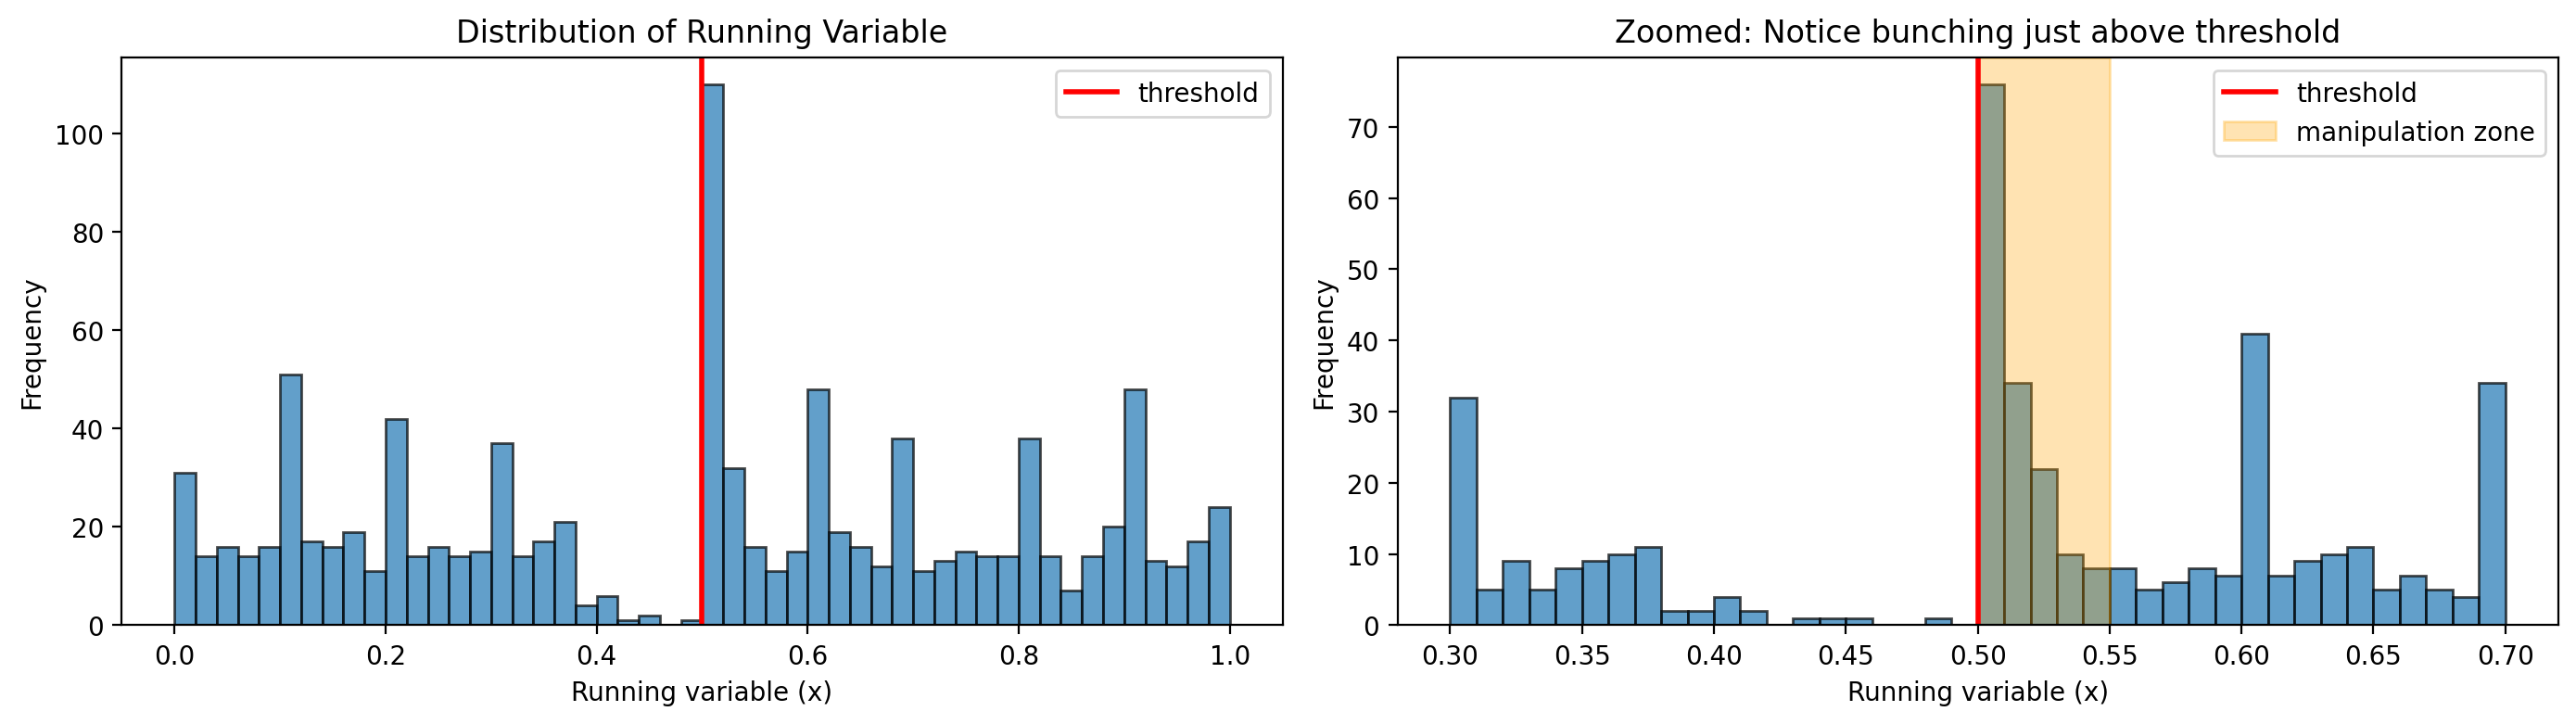

Observations just below threshold (0.45-0.50): 2
Observations just above threshold (0.50-0.55): 150
Ratio (above/below): 75.00

This asymmetry suggests manipulation - individuals sorting from below to above the threshold.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left panel: Full distribution
ax = axes[0]
ax.hist(df["x"], bins=50, edgecolor="black", alpha=0.7)
ax.axvline(x=THRESHOLD, color="r", linestyle="-", linewidth=2, label="threshold")
ax.set_xlabel("Running variable (x)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Running Variable")
ax.legend()

# Right panel: Zoomed in near threshold to show bunching
ax = axes[1]
near_threshold = df[(df["x"] >= 0.3) & (df["x"] <= 0.7)]
ax.hist(near_threshold["x"], bins=40, edgecolor="black", alpha=0.7)
ax.axvline(x=THRESHOLD, color="r", linestyle="-", linewidth=2, label="threshold")
ax.axvspan(
    THRESHOLD, THRESHOLD + 0.05, alpha=0.3, color="orange", label="manipulation zone"
)
ax.set_xlabel("Running variable (x)")
ax.set_ylabel("Frequency")
ax.set_title("Zoomed: Notice bunching just above threshold")
ax.legend()

plt.tight_layout()
plt.show()

# Count observations in key regions
below = (df["x"] >= THRESHOLD - 0.05) & (df["x"] < THRESHOLD)
above = (df["x"] >= THRESHOLD) & (df["x"] < THRESHOLD + 0.05)
print(f"Observations just below threshold (0.45-0.50): {below.sum()}")
print(f"Observations just above threshold (0.50-0.55): {above.sum()}")
print(f"Ratio (above/below): {above.sum() / max(below.sum(), 1):.2f}")
print(
    "\nThis asymmetry suggests manipulation - individuals sorting from below to above the threshold."
)

### Interpreting the Density Plots

The density plots reveal two distinct phenomena in our synthetic data:

**1. Bunching just above threshold → Evidence of MANIPULATION**

The zoomed plot shows dramatically more observations just above 0.5 than just below. The ratio is 75:1! This is the classic signature of strategic sorting - students who would have scored 45-49 have pushed themselves above the threshold. In our scholarship story, these are the motivated strivers.

This bunching is what causes the **bias** in our simulation. Because these students are systematically more motivated (and would have better outcomes regardless of the scholarship), including them in the RDD comparison inflates the estimated treatment effect.

**2. Spikes at round numbers → Evidence of HEAPING**

Notice the visible spikes at 0.3, 0.4, 0.6, and 0.7 in the full distribution. These occur because we simulated some scores being rounded to the nearest 0.1 (as might happen if exam scores are reported in 10-point increments).

In our simulation, this heaping is **cosmetic** - it doesn't cause bias because the rounding isn't correlated with outcomes. However, in real data, heaping could be problematic if:
- The threshold itself is at a round number (as it often is)
- Rounding conventions differ systematically across outcome groups
- Measurement error from rounding is correlated with covariates

**The key insight:** Both bunching and heaping manifest as irregularities in the running variable distribution near the threshold. Donut RDD addresses both by excluding these observations. In our case, excluding observations near the threshold primarily helps by removing the biased manipulators.


## Baseline: Standard RDD (Biased by Manipulation)

First, let's fit a standard RDD without any donut hole exclusion. We use a bandwidth to focus on observations near the threshold - this is where manipulation matters most, and where the bias will be visible.

Since we generated the data, we know the **true causal effect is 0.5**. Let's see if the standard RDD recovers this value, or if the manipulation biases our estimate.


In [5]:
# Define bandwidth for local estimation (used throughout this notebook)
BANDWIDTH = 0.25

result_baseline = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=BANDWIDTH,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


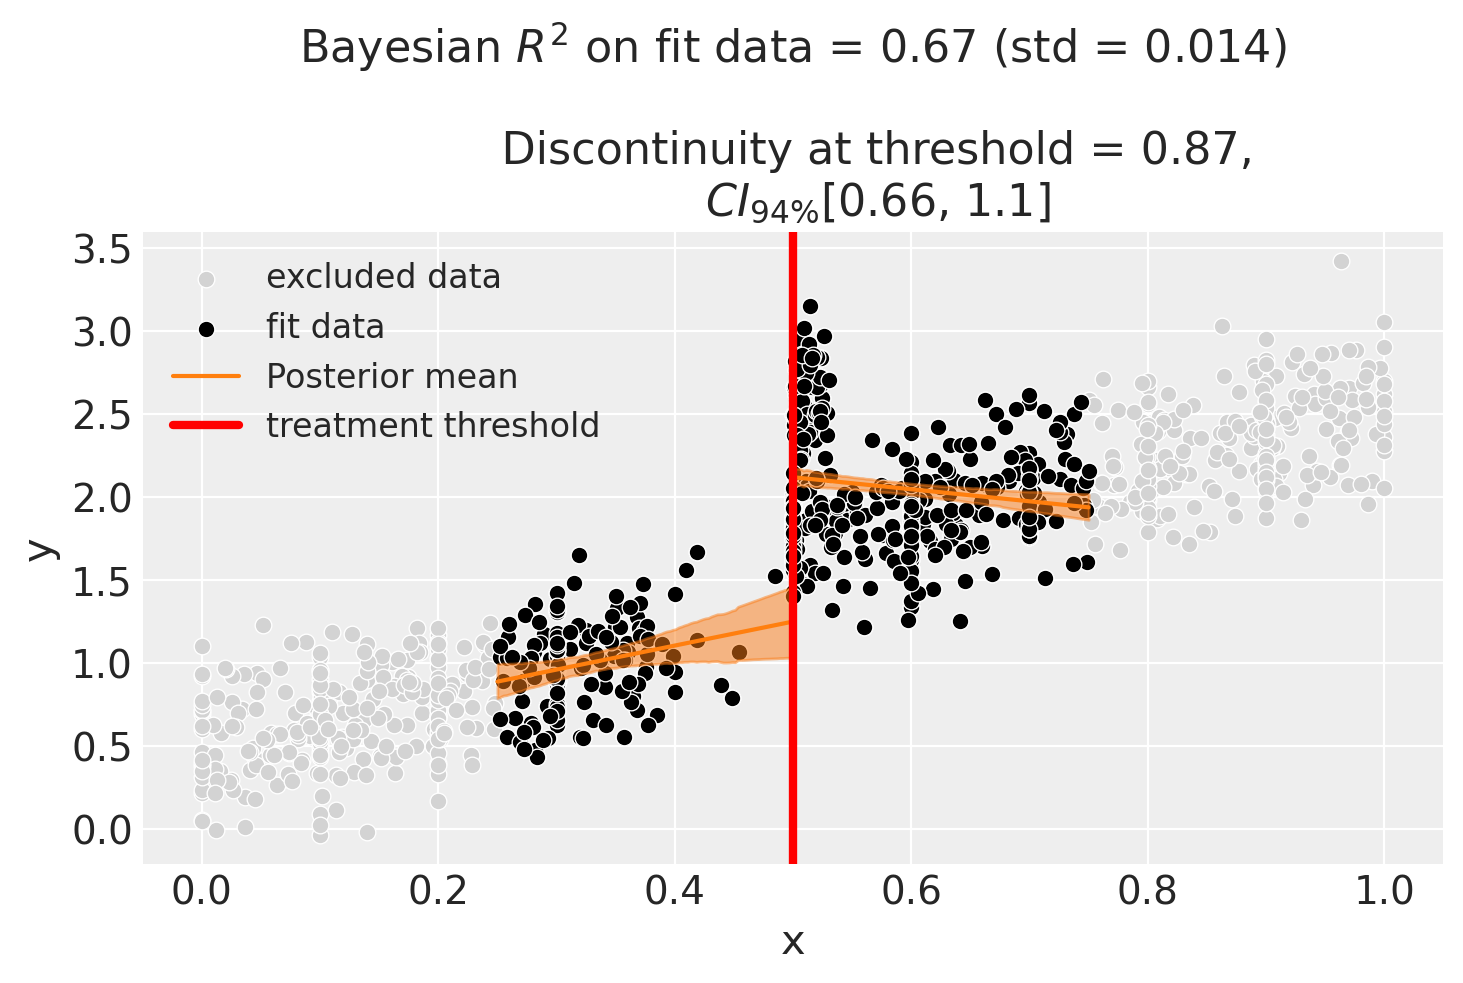

In [6]:
fig, ax = result_baseline.plot()

# Add true effect annotation (for synthetic data parameter recovery)
baseline_estimate = float(result_baseline.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {baseline_estimate:.2f}\nBias: {baseline_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)
plt.show()

In [7]:
result_baseline.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.25
Donut hole: 0.0
Observations used for fit: 488

Results:
Discontinuity at threshold = 0.87$CI_{94\%}$[0.66, 1.1]


Model coefficients:
    Intercept          0.53, 94% HDI [0.16, 0.91]
    treated[T.True]    2, 94% HDI [1.5, 2.4]
    x                  1.4, 94% HDI [0.27, 2.6]
    x:treated[T.True]  -2.2, 94% HDI [-3.4, -0.89]
    y_hat_sigma        0.34, 94% HDI [0.32, 0.36]


## Using the `donut_hole` Parameter to Remove Bias

The standard RDD estimate is biased upward because manipulators (who have systematically higher outcomes) are included in the fit. By using `donut_hole=0.04`, we exclude observations within 0.04 units of the threshold - precisely where the manipulators are bunched.

Let's see if this recovers the true effect:


In [8]:
result_donut = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=BANDWIDTH,
    donut_hole=0.04,  # Exclude observations within 0.04 of threshold
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


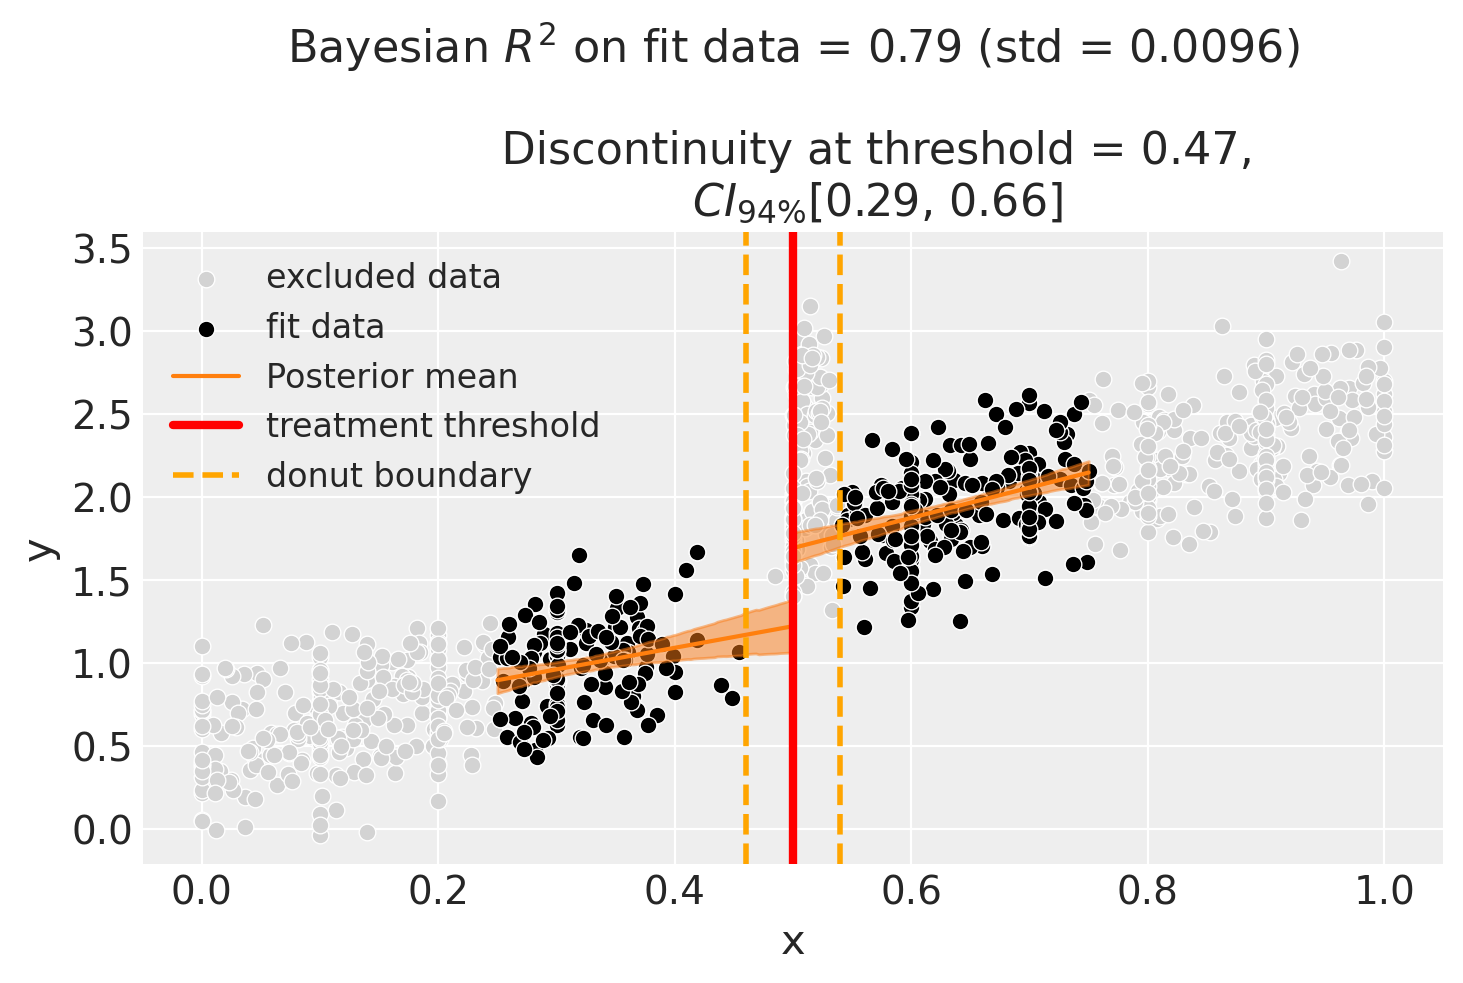

In [9]:
fig, ax = result_donut.plot()

# Add true effect annotation (for synthetic data parameter recovery)
donut_estimate = float(result_donut.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {donut_estimate:.2f}\nBias: {donut_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.8),
)
plt.show()

Notice in the plot:
- **Light gray points**: Observations excluded from model fitting (within the donut hole) - this includes the manipulators!
- **Black points**: Observations used for model fitting
- **Orange dashed lines**: Donut hole boundaries at threshold ± donut_hole

The donut RDD estimate is now much closer to the true effect of 0.5, demonstrating how excluding problematic observations can reduce bias.


In [10]:
result_donut.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.25
Donut hole: 0.04
Observations used for fit: 345

Results:
Discontinuity at threshold = 0.47$CI_{94\%}$[0.29, 0.66]


Model coefficients:
    Intercept          0.57, 94% HDI [0.28, 0.85]
    treated[T.True]    0.21, 94% HDI [-0.26, 0.68]
    x                  1.3, 94% HDI [0.44, 2.2]
    x:treated[T.True]  0.52, 94% HDI [-0.51, 1.6]
    y_hat_sigma        0.25, 94% HDI [0.23, 0.27]


## Alternative: Larger Bandwidth with Donut

We can also explore using a larger bandwidth with the donut. This includes more data (reducing variance) while still excluding the problematic observations near the threshold.


In [11]:
result_combined = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=0.3,
    donut_hole=0.05,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


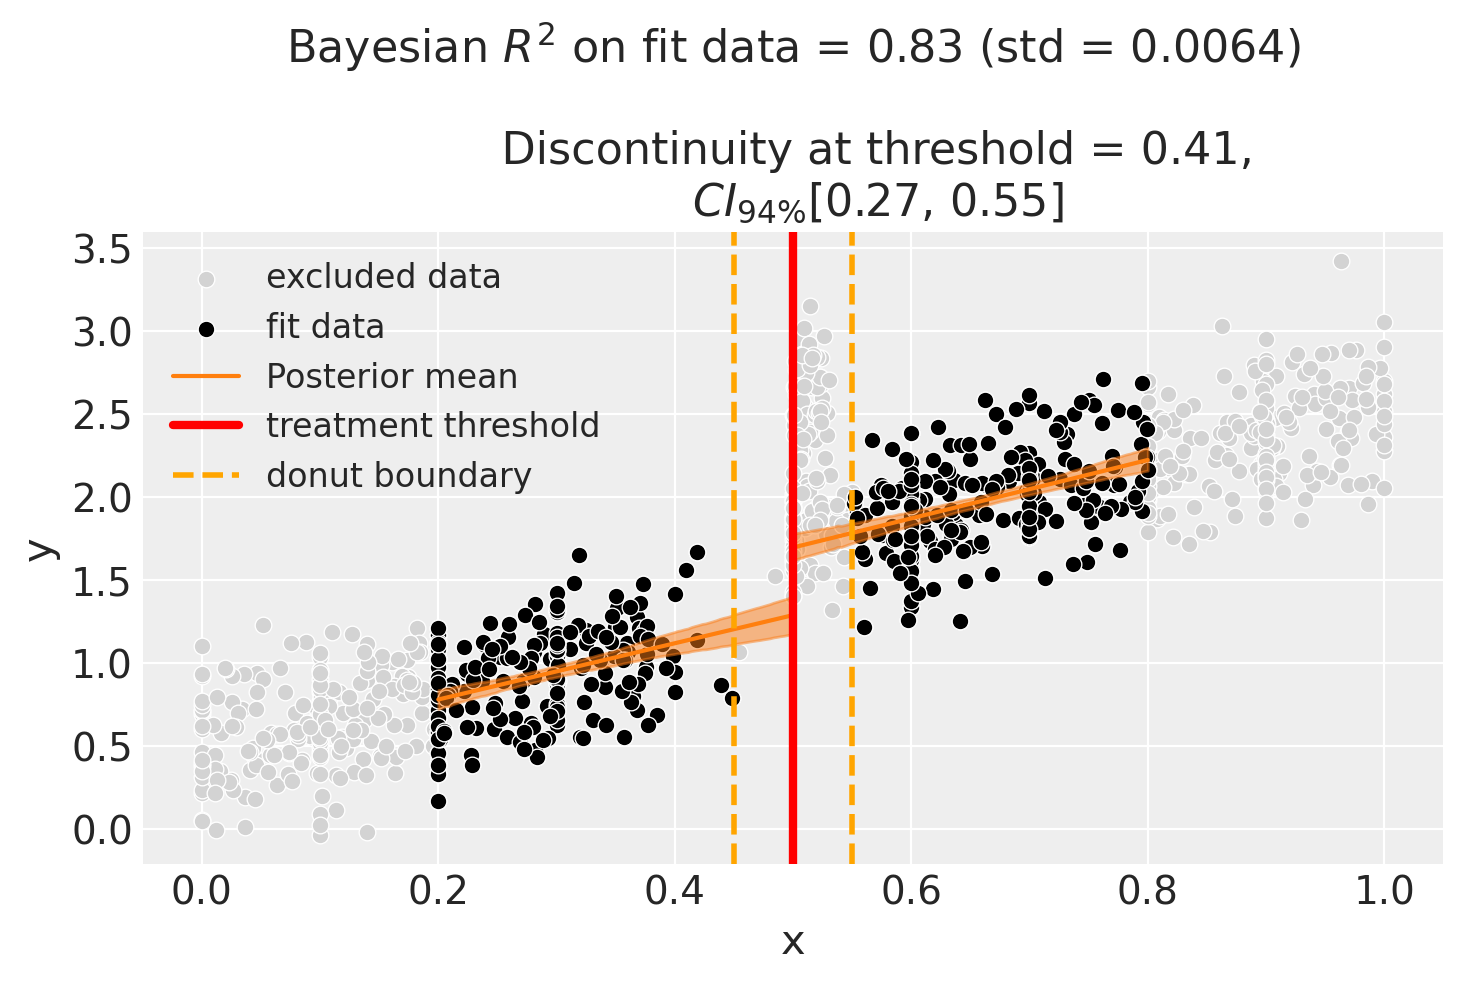

In [12]:
fig, ax = result_combined.plot()

# Add true effect annotation
combined_estimate = float(result_combined.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {combined_estimate:.2f}\nBias: {combined_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8),
)
plt.show()

In [13]:
result_combined.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.3
Donut hole: 0.05
Observations used for fit: 436

Results:
Discontinuity at threshold = 0.41$CI_{94\%}$[0.27, 0.55]


Model coefficients:
    Intercept          0.44, 94% HDI [0.29, 0.6]
    treated[T.True]    0.38, 94% HDI [0.033, 0.7]
    x                  1.7, 94% HDI [1.2, 2.2]
    x:treated[T.True]  0.064, 94% HDI [-0.6, 0.75]
    y_hat_sigma        0.25, 94% HDI [0.23, 0.27]


## Sensitivity Analysis: Varying the Donut Hole Size

A key use of donut RDD is as a robustness check. By varying the `donut_hole` parameter, we can assess how sensitive the estimated discontinuity is to excluding observations near the threshold.

**Important**: We use a bandwidth here to focus on observations near the threshold. This makes the manipulators a larger fraction of the local sample, so their bias effect becomes visible. With infinite bandwidth, the manipulators would be diluted among all observations.


In [14]:
# Use the same bandwidth as earlier - this focuses on local data
# making manipulators a larger fraction of the sample
donut_sizes = np.linspace(0, 0.1, 11)
results = []

for d in donut_sizes:
    result = cp.RegressionDiscontinuity(
        df,
        formula="y ~ 1 + x + treated + x:treated",
        model=cp.pymc_models.LinearRegression(
            sample_kwargs={"random_seed": seed, "progressbar": False}
        ),
        treatment_threshold=THRESHOLD,
        donut_hole=d,
        bandwidth=BANDWIDTH,
    )

    # Extract the mean discontinuity estimate
    mean_effect = float(result.discontinuity_at_threshold.mean())
    hdi_low = float(result.discontinuity_at_threshold.quantile(0.03))
    hdi_high = float(result.discontinuity_at_threshold.quantile(0.97))
    n_fit = len(result.fit_data)
    bias = mean_effect - TRUE_EFFECT

    results.append(
        {
            "donut_hole": d,
            "mean_effect": mean_effect,
            "hdi_low": hdi_low,
            "hdi_high": hdi_high,
            "n_fit": n_fit,
            "bias": bias,
        }
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS usin

In [15]:
sensitivity_df = pd.DataFrame(results)
sensitivity_df

,donut_hole,mean_effect,hdi_low,hdi_high,n_fit,bias
0,0.00,0.870401,0.659712,1.090459,488,0.370401
1,0.01,0.829329,0.622522,1.040355,412,0.329329
2,0.02,0.708946,0.513059,0.906670,377,0.208946
3,0.03,0.500546,0.315674,0.683900,355,0.000546
4,0.04,0.474265,0.288691,0.657024,345,-0.025735
5,0.05,0.454360,0.267844,0.651620,336,-0.045640
6,0.06,0.421624,0.211732,0.634796,327,-0.078376
7,0.07,0.380367,0.174582,0.593219,321,-0.119633
8,0.08,0.366085,0.155353,0.582921,315,-0.133915
9,0.09,0.389519,0.156260,0.619393,305,-0.110481


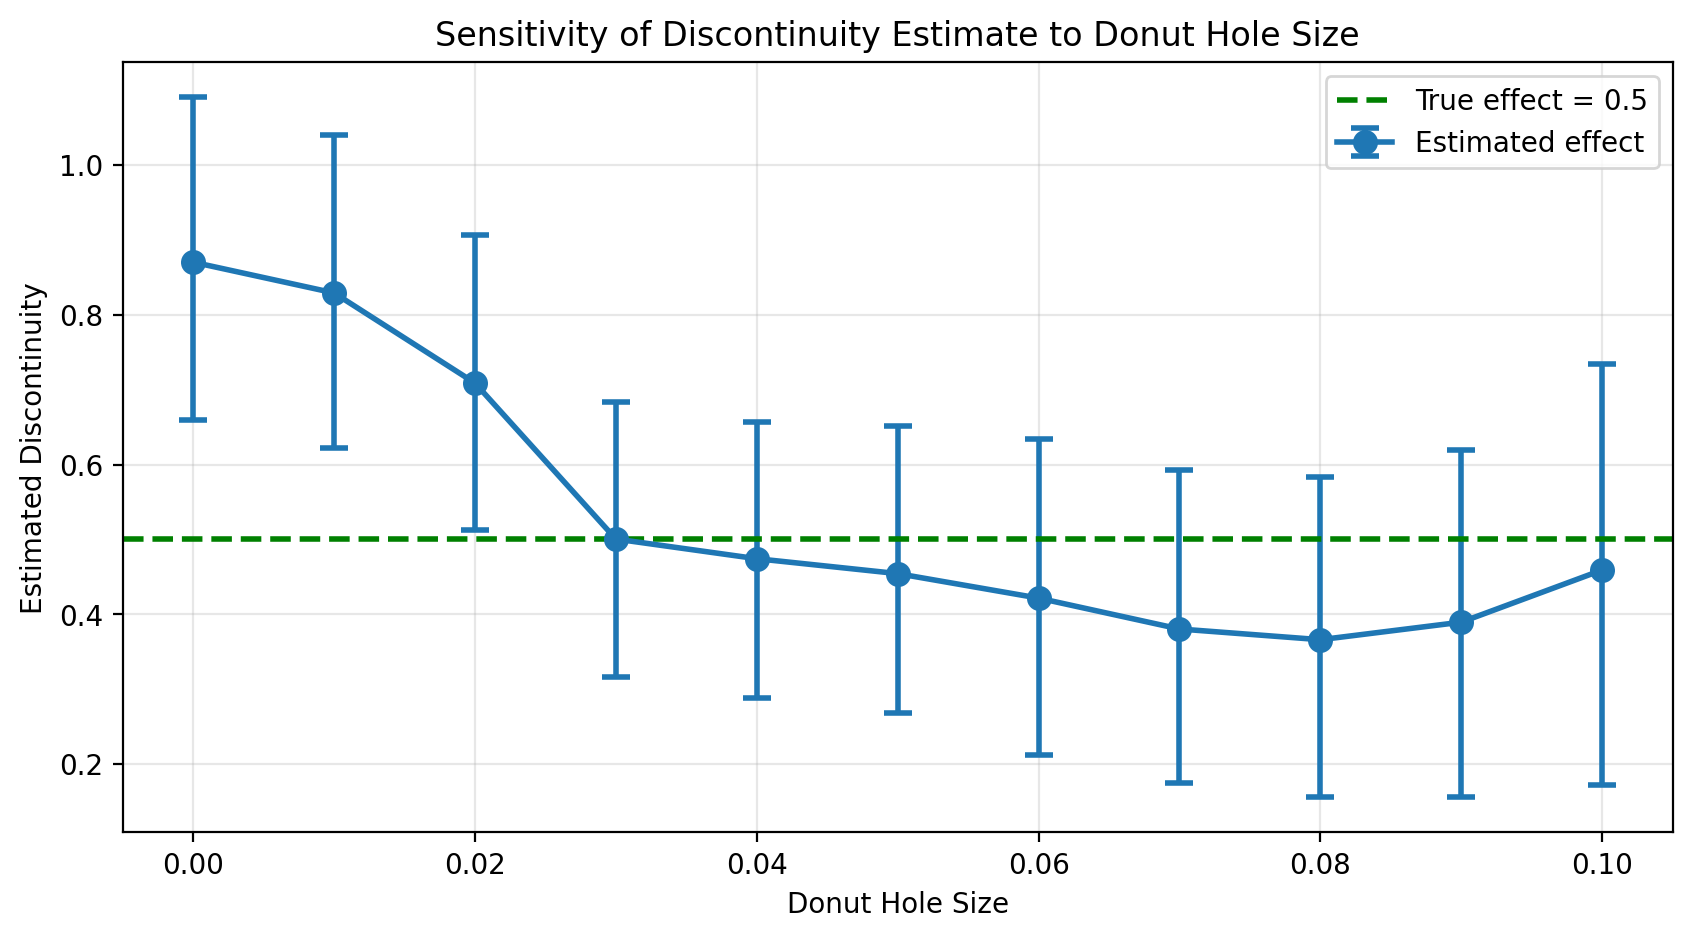

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(
    sensitivity_df["donut_hole"],
    sensitivity_df["mean_effect"],
    yerr=[
        sensitivity_df["mean_effect"] - sensitivity_df["hdi_low"],
        sensitivity_df["hdi_high"] - sensitivity_df["mean_effect"],
    ],
    marker="o",
    capsize=5,
    capthick=2,
    linewidth=2,
    markersize=8,
    label="Estimated effect",
)

# Add true effect line
ax.axhline(
    y=TRUE_EFFECT,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"True effect = {TRUE_EFFECT}",
)

ax.set_xlabel("Donut Hole Size")
ax.set_ylabel("Estimated Discontinuity")
ax.set_title("Sensitivity of Discontinuity Estimate to Donut Hole Size")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

The sensitivity plot reveals the story:

1. **With no donut hole (d=0)**, the estimate is biased upward due to manipulation
2. **As the donut grows**, the estimate moves toward the true effect (green line)
3. **Stability at larger donut sizes** suggests we've successfully excluded the problematic observations

This is the hallmark of a successful donut RDD analysis: the estimate converges toward a stable value as we exclude more observations near the threshold, and that stable value is closer to the truth.


## Summary: Comparing Estimates to Ground Truth

Since we used synthetic data with a known true effect, we can directly compare how well each approach recovers the true causal effect:


In [17]:
# Create comparison table
comparison_data = {
    "Method": [
        "True Effect",
        "Standard RDD (no donut)",
        "Donut RDD (d=0.05)",
        "Donut RDD + Bandwidth (d=0.05, h=0.3)",
    ],
    "Estimate": [
        TRUE_EFFECT,
        baseline_estimate,
        donut_estimate,
        combined_estimate,
    ],
    "Bias": [
        0.0,
        baseline_estimate - TRUE_EFFECT,
        donut_estimate - TRUE_EFFECT,
        combined_estimate - TRUE_EFFECT,
    ],
    "Observations Used": [
        "-",
        len(result_baseline.fit_data),
        len(result_donut.fit_data),
        len(result_combined.fit_data),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Estimate"] = comparison_df["Estimate"].apply(lambda x: f"{x:.3f}")
comparison_df["Bias"] = comparison_df["Bias"].apply(lambda x: f"{x:+.3f}")
comparison_df.style.set_caption("Parameter Recovery: Standard RDD vs Donut RDD")

,Method,Estimate,Bias,Observations Used
0,True Effect,0.500,+0.000,-
1,Standard RDD (no donut),0.870,+0.370,488
2,Donut RDD (d=0.05),0.474,-0.026,345
3,"Donut RDD + Bandwidth (d=0.05, h=0.3)",0.411,-0.089,436


**Key findings:**
- The **standard RDD** overestimates the effect due to manipulation - manipulators have higher outcomes and are incorrectly attributed to the treatment
- **Donut RDD** substantially reduces bias by excluding the manipulated observations
- The **combined approach** (donut + bandwidth) provides the best estimate in this case

:::{note}
In real-world applications, you won't know the true effect. The value of this synthetic exercise is to demonstrate *why* donut RDD works and build intuition for interpreting sensitivity analyses. When estimates stabilize as the donut grows, it suggests you've excluded the problematic observations.
:::


## Interpretation Cautions

While donut RDD is a useful robustness technique, it comes with important caveats:

1. **Increased variance**: Removing observations closest to the threshold reduces sample size and increases estimation uncertainty.

2. **Reliance on functional form**: With less data near the threshold, the estimate relies more heavily on the assumed functional form (e.g., linear, polynomial).

3. **Not a fix for all problems**: If the entire dataset is affected by manipulation or measurement issues, donut RDD alone may not resolve them.

4. **Complementary diagnostics**: Donut RDD should be used alongside other diagnostics like the McCrary density test, covariate balance checks, and bandwidth sensitivity analysis.

For a thorough treatment of these issues, see {cite:t}`noack2024donut`.


## Other Scenarios to Consider

This notebook demonstrated one specific data generating process: **motivated strivers sorting upward**, which creates **upward bias**. We chose this scenario because it's intuitive and commonly discussed in the RDD literature.

However, other mechanisms exist, and donut RDD is useful for all of them:

**Alternative mechanisms that could cause bias:**

1. **Low-ability gaming (downward bias):** If manipulators were low-ability individuals cheating to barely pass (rather than motivated students legitimately working harder), they would have systematically *worse* outcomes. This would cause the standard RDD to *underestimate* the treatment effect.

2. **Heaping with outcome correlation:** If scores were rounded to the threshold value (e.g., teachers rounding 48s up to 50), and the students whose scores get rounded differ systematically from those who don't, this could bias RDD estimates even without strategic sorting.

3. **Caseworker discretion:** In some programs, caseworkers can adjust eligibility scores. If caseworkers systematically help certain types of applicants cross the threshold, this creates sorting similar to our scholarship example.

**The unifying insight:** Donut RDD is agnostic to the specific mechanism. Whenever observations near the threshold might be systematically different from those farther away - for any reason - excluding them and checking whether estimates change is a valuable robustness exercise.

:::{note}
When you find that donut RDD changes your estimates substantially, this is a diagnostic signal that something unusual is happening near the threshold. It doesn't tell you *what* that something is - you'll need domain knowledge and additional diagnostics (like the McCrary density test or covariate balance checks) to understand the mechanism.
:::


---

Comparing the models

We can get nicely formatted tables from our integration with the [maketables](https://github.com/py-econometrics/maketables) package.

In [18]:
from maketables import ETable

ETable([result_baseline, result_donut, result_combined], coef_fmt="b:.3f")

<maketables.mtable.MTable.__repr__.<locals>.DualOutput at 0x322def380>

## References

:::{bibliography}
:filter: docname in docnames
:::
